In [ ]:
%load_ext autoreload
# %load_ext cudf.pandas
%autoreload 2

import os
import sqlite3
import utils as u
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import product

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)

ModuleNotFoundError: No module named 'cupy'

**Load in data**

In [2]:
if not os.path.exists("./data/data.db"):
    os.system("python3.11 build_db.py")

conn = sqlite3.connect("./data/data.db")
c = conn.cursor()


COLS_EXCLUDE = set([
    "StateAbbr",
    "StateDesc",
    "CountyName",
    "CountyFIPS",
    "TractFIPS",
    "fips",
    "stateabb",
    "sedaadmin",
    "sedaadminname",
    "TRACT",
    "COUNT"
])

if not os.path.exists("./data/full_joined_table.csv"):
    c.execute(f"""
    WITH seda_tracts AS (
        SELECT *
        FROM seda s
        JOIN nces n
        ON s.sedaadmin = n.LEAID
        WHERE s.year = 2019
    )

    , food_atlas_tracts AS (
        SELECT *
        FROM food f
        JOIN seda_tracts st
        ON st.TRACT = f.CensusTract
    )

    , cdc_tracts AS (
        SELECT *
        FROM cdc c
        JOIN food_atlas_tracts ft
        ON ft.TRACT = c.TractFIPS
    )

    SELECT *
    FROM cdc_tracts;
    """)

    rows = c.fetchall()
    print(len(rows))
    columns = [col[0] for col in c.description]

    ## Write the rows manually into a CSV file without pandas
    to_remove = [
        "StateAbbr",
        "CountyName",
        "TractFIPS",
        "stateabb",
        "MHLTH_CrudePrev:1",
        "SLEEP_CrudePrev:1",
        "fips",
        "LEAID",
        "NAME_LEA19",
        "TRACT",
        "COUNT"
    ]
    to_remove_idx = set([i for i, col in enumerate(columns) if col in to_remove])
    with open("data/full_joined_table.csv", "w") as f:
        race_cols = []
        f.write(",".join([col for i, col in enumerate(columns) if i not in to_remove_idx]) + "\n")
        for row in tqdm(rows):
            # if row[0] == "CA":
            f.write(",".join([str(x) for i, x in enumerate(row) if i not in to_remove_idx]) + "\n")


In [3]:
df = pd.read_csv("data/full_joined_table.csv")
print(df.shape)
df.head()

(995894, 68)


,MHLTH_CrudePrev,SLEEP_CrudePrev,CensusTract,State,County,Urban,LATracts_half,LATracts10,PovertyRate,LowIncomeTracts,...,tot_asmt_whg,gcs_mn_wht,gcs_mn_se_wht,tot_asmt_wht,gcs_mn_wng,gcs_mn_se_wng,tot_asmt_wng,last_bie,LANDAREA,WATERAREA
0,18.6,36.9,1095030701,Alabama,Marshall County,0,0,0,26.0,1,...,418.0,2.579603,0.241355,166.0,NaN,NaN,NaN,0,2.116012,0.000000
1,18.9,37.3,1095030702,Alabama,Marshall County,0,0,0,15.2,0,...,418.0,2.579603,0.241355,166.0,NaN,NaN,NaN,0,0.800889,0.009930
2,19.5,38.4,1095030801,Alabama,Marshall County,1,1,0,29.9,1,...,418.0,2.579603,0.241355,166.0,NaN,NaN,NaN,0,5.437714,0.012075
3,21.9,40.2,1095030802,Alabama,Marshall County,1,1,0,39.2,1,...,418.0,2.579603,0.241355,166.0,NaN,NaN,NaN,0,5.297315,0.017784
4,15.8,35.2,1095030902,Alabama,Marshall County,1,1,0,13.7,0,...,418.0,2.579603,0.241355,166.0,NaN,NaN,NaN,0,7.293396,0.033274


<Axes: >

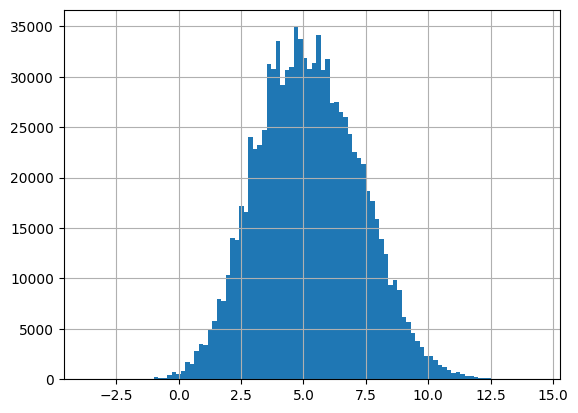

In [4]:
df.gcs_mn_all.hist(bins=100)

<Axes: >

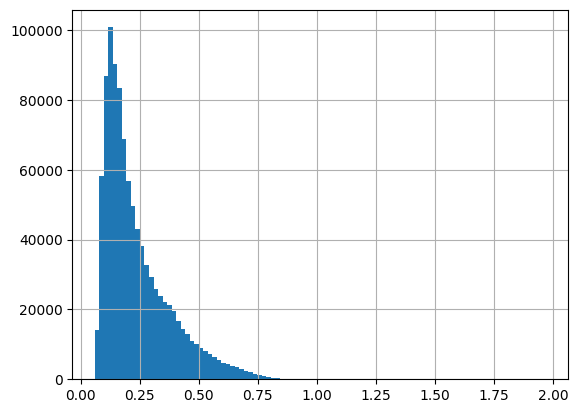

In [5]:
df.gcs_mn_se_all.hist(bins=100)

In [6]:
meta_data_cols = [
    "CensusTract",
    "State",
    "County",
    "sedaadmin",
    "sedaadminname",
    "subject",
    "grade"
]

health_feature_cols = [
    "MHLTH_CrudePrev", # cont
    "SLEEP_CrudePrev", # cont
]

food_desert_cols = [
    "Urban",            # bool
    "LATracts_half",    # bool
    "LATracts10",       # bool
    "PovertyRate",      # cont
    "LowIncomeTracts",  # bool
    "lahunvhalfshare",  # bool
    "lahunv10share",    # bool
]

academics_all_cols = [
    "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_asn", "gcs_mn_se_asn", "tot_asmt_asn",
    "gcs_mn_blk", "gcs_mn_se_blk", "tot_asmt_blk",
    "gcs_mn_ecd", "gcs_mn_se_ecd", "tot_asmt_ecd",
    "gcs_mn_fem", "gcs_mn_se_fem", "tot_asmt_fem",
    "gcs_mn_hsp", "gcs_mn_se_hsp", "tot_asmt_hsp",
    "gcs_mn_mal", "gcs_mn_se_mal", "tot_asmt_mal",
    "gcs_mn_mfg", "gcs_mn_se_mfg", "tot_asmt_mfg",
    "gcs_mn_nam", "gcs_mn_se_nam", "tot_asmt_nam",
    "gcs_mn_nec", "gcs_mn_se_nec", "tot_asmt_nec",
    "gcs_mn_neg", "gcs_mn_se_neg", "tot_asmt_neg",
    "gcs_mn_wag", "gcs_mn_se_wag", "tot_asmt_wag",
    "gcs_mn_wbg", "gcs_mn_se_wbg", "tot_asmt_wbg",
    "gcs_mn_whg", "gcs_mn_se_whg", "tot_asmt_whg",
    "gcs_mn_wht", "gcs_mn_se_wht", "tot_asmt_wht",
    "gcs_mn_wng", "gcs_mn_se_wng", "tot_asmt_wng",
]

academics_race_cols = [
    "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_wht", "gcs_mn_se_wht", "tot_asmt_wht",
    "gcs_mn_asn", "gcs_mn_se_asn", "tot_asmt_asn",
    "gcs_mn_blk", "gcs_mn_se_blk", "tot_asmt_blk",
    "gcs_mn_hsp", "gcs_mn_se_hsp", "tot_asmt_hsp",
    "gcs_mn_nam", "gcs_mn_se_nam", "tot_asmt_nam",
]

academics_gender_cols = [
    # "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_fem", "gcs_mn_se_fem", "tot_asmt_fem",
    "gcs_mn_mal", "gcs_mn_se_mal", "tot_asmt_mal",
]

**Classification/clustering by race**

In [7]:
# Exclude lahunv10share since it is mostly NaN
feature_cols = academics_all_cols + health_feature_cols
race_df = df[academics_all_cols + health_feature_cols + food_desert_cols[:-1] + meta_data_cols].copy()
print(f"Original length: {len(race_df)}")
race_df = race_df.dropna().reset_index(drop=True)
race_df["y"] = race_df.apply(lambda row: str(row["Urban"]) + str(row["LATracts_half"]), axis=1)
print(f"Length after dropping NaNs: {len(race_df)}")
race_df.head()

Original length: 995894
Length after dropping NaNs: 94513


,gcs_mn_all,gcs_mn_se_all,tot_asmt_all,gcs_mn_asn,gcs_mn_se_asn,tot_asmt_asn,gcs_mn_blk,gcs_mn_se_blk,tot_asmt_blk,gcs_mn_ecd,...,LowIncomeTracts,lahunvhalfshare,CensusTract,State,County,sedaadmin,sedaadminname,subject,grade,y
0,2.904942,0.155331,1381,4.113537,0.635675,23.0,1.939849,0.215863,282.0,1.98222,...,1,17.76,1089000201,Alabama,Madison County,102220,Madison County,mth,3,00
1,2.904942,0.155331,1381,4.113537,0.635675,23.0,1.939849,0.215863,282.0,1.98222,...,1,4.06,1089000403,Alabama,Madison County,102220,Madison County,mth,3,11
2,2.904942,0.155331,1381,4.113537,0.635675,23.0,1.939849,0.215863,282.0,1.98222,...,0,6.85,1089000901,Alabama,Madison County,102220,Madison County,mth,3,11
3,2.904942,0.155331,1381,4.113537,0.635675,23.0,1.939849,0.215863,282.0,1.98222,...,0,0.49,1089001401,Alabama,Madison County,102220,Madison County,mth,3,11
4,2.904942,0.155331,1381,4.113537,0.635675,23.0,1.939849,0.215863,282.0,1.98222,...,1,4.24,1089001402,Alabama,Madison County,102220,Madison County,mth,3,11


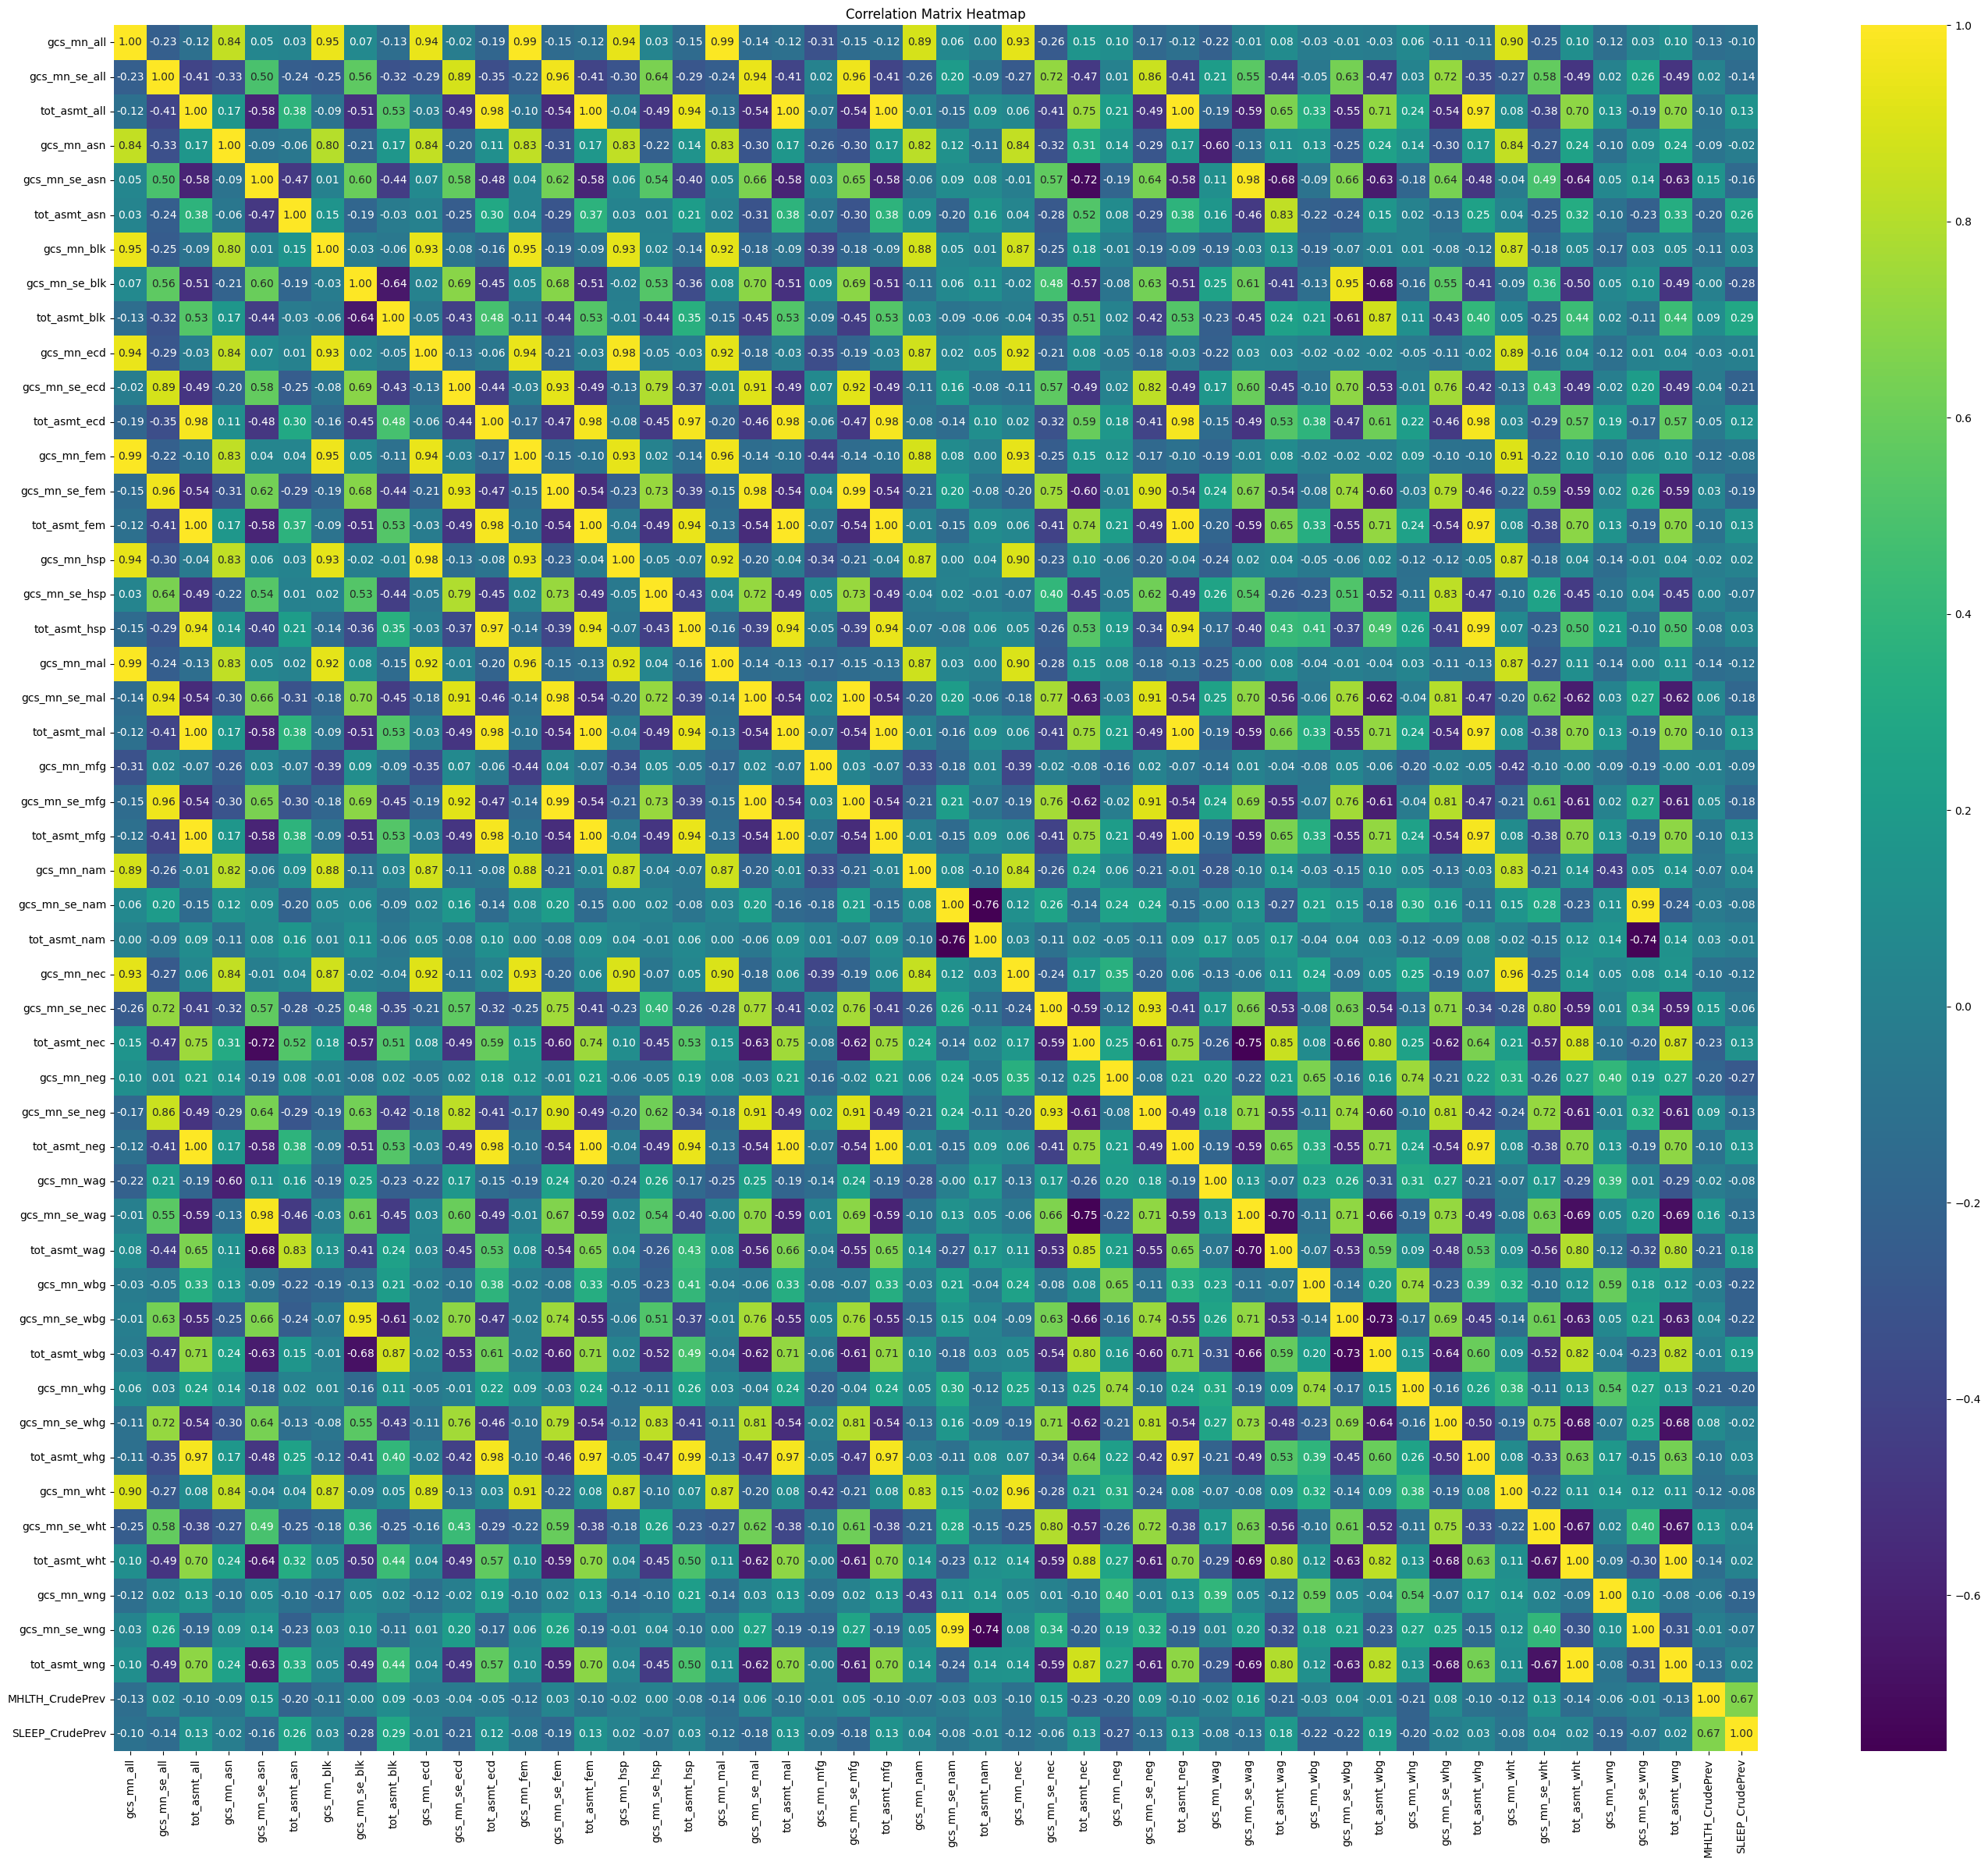

In [8]:
corr_map = race_df[feature_cols].corr()
plt.figure(figsize=(28, 24))
sns.heatmap(corr_map, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

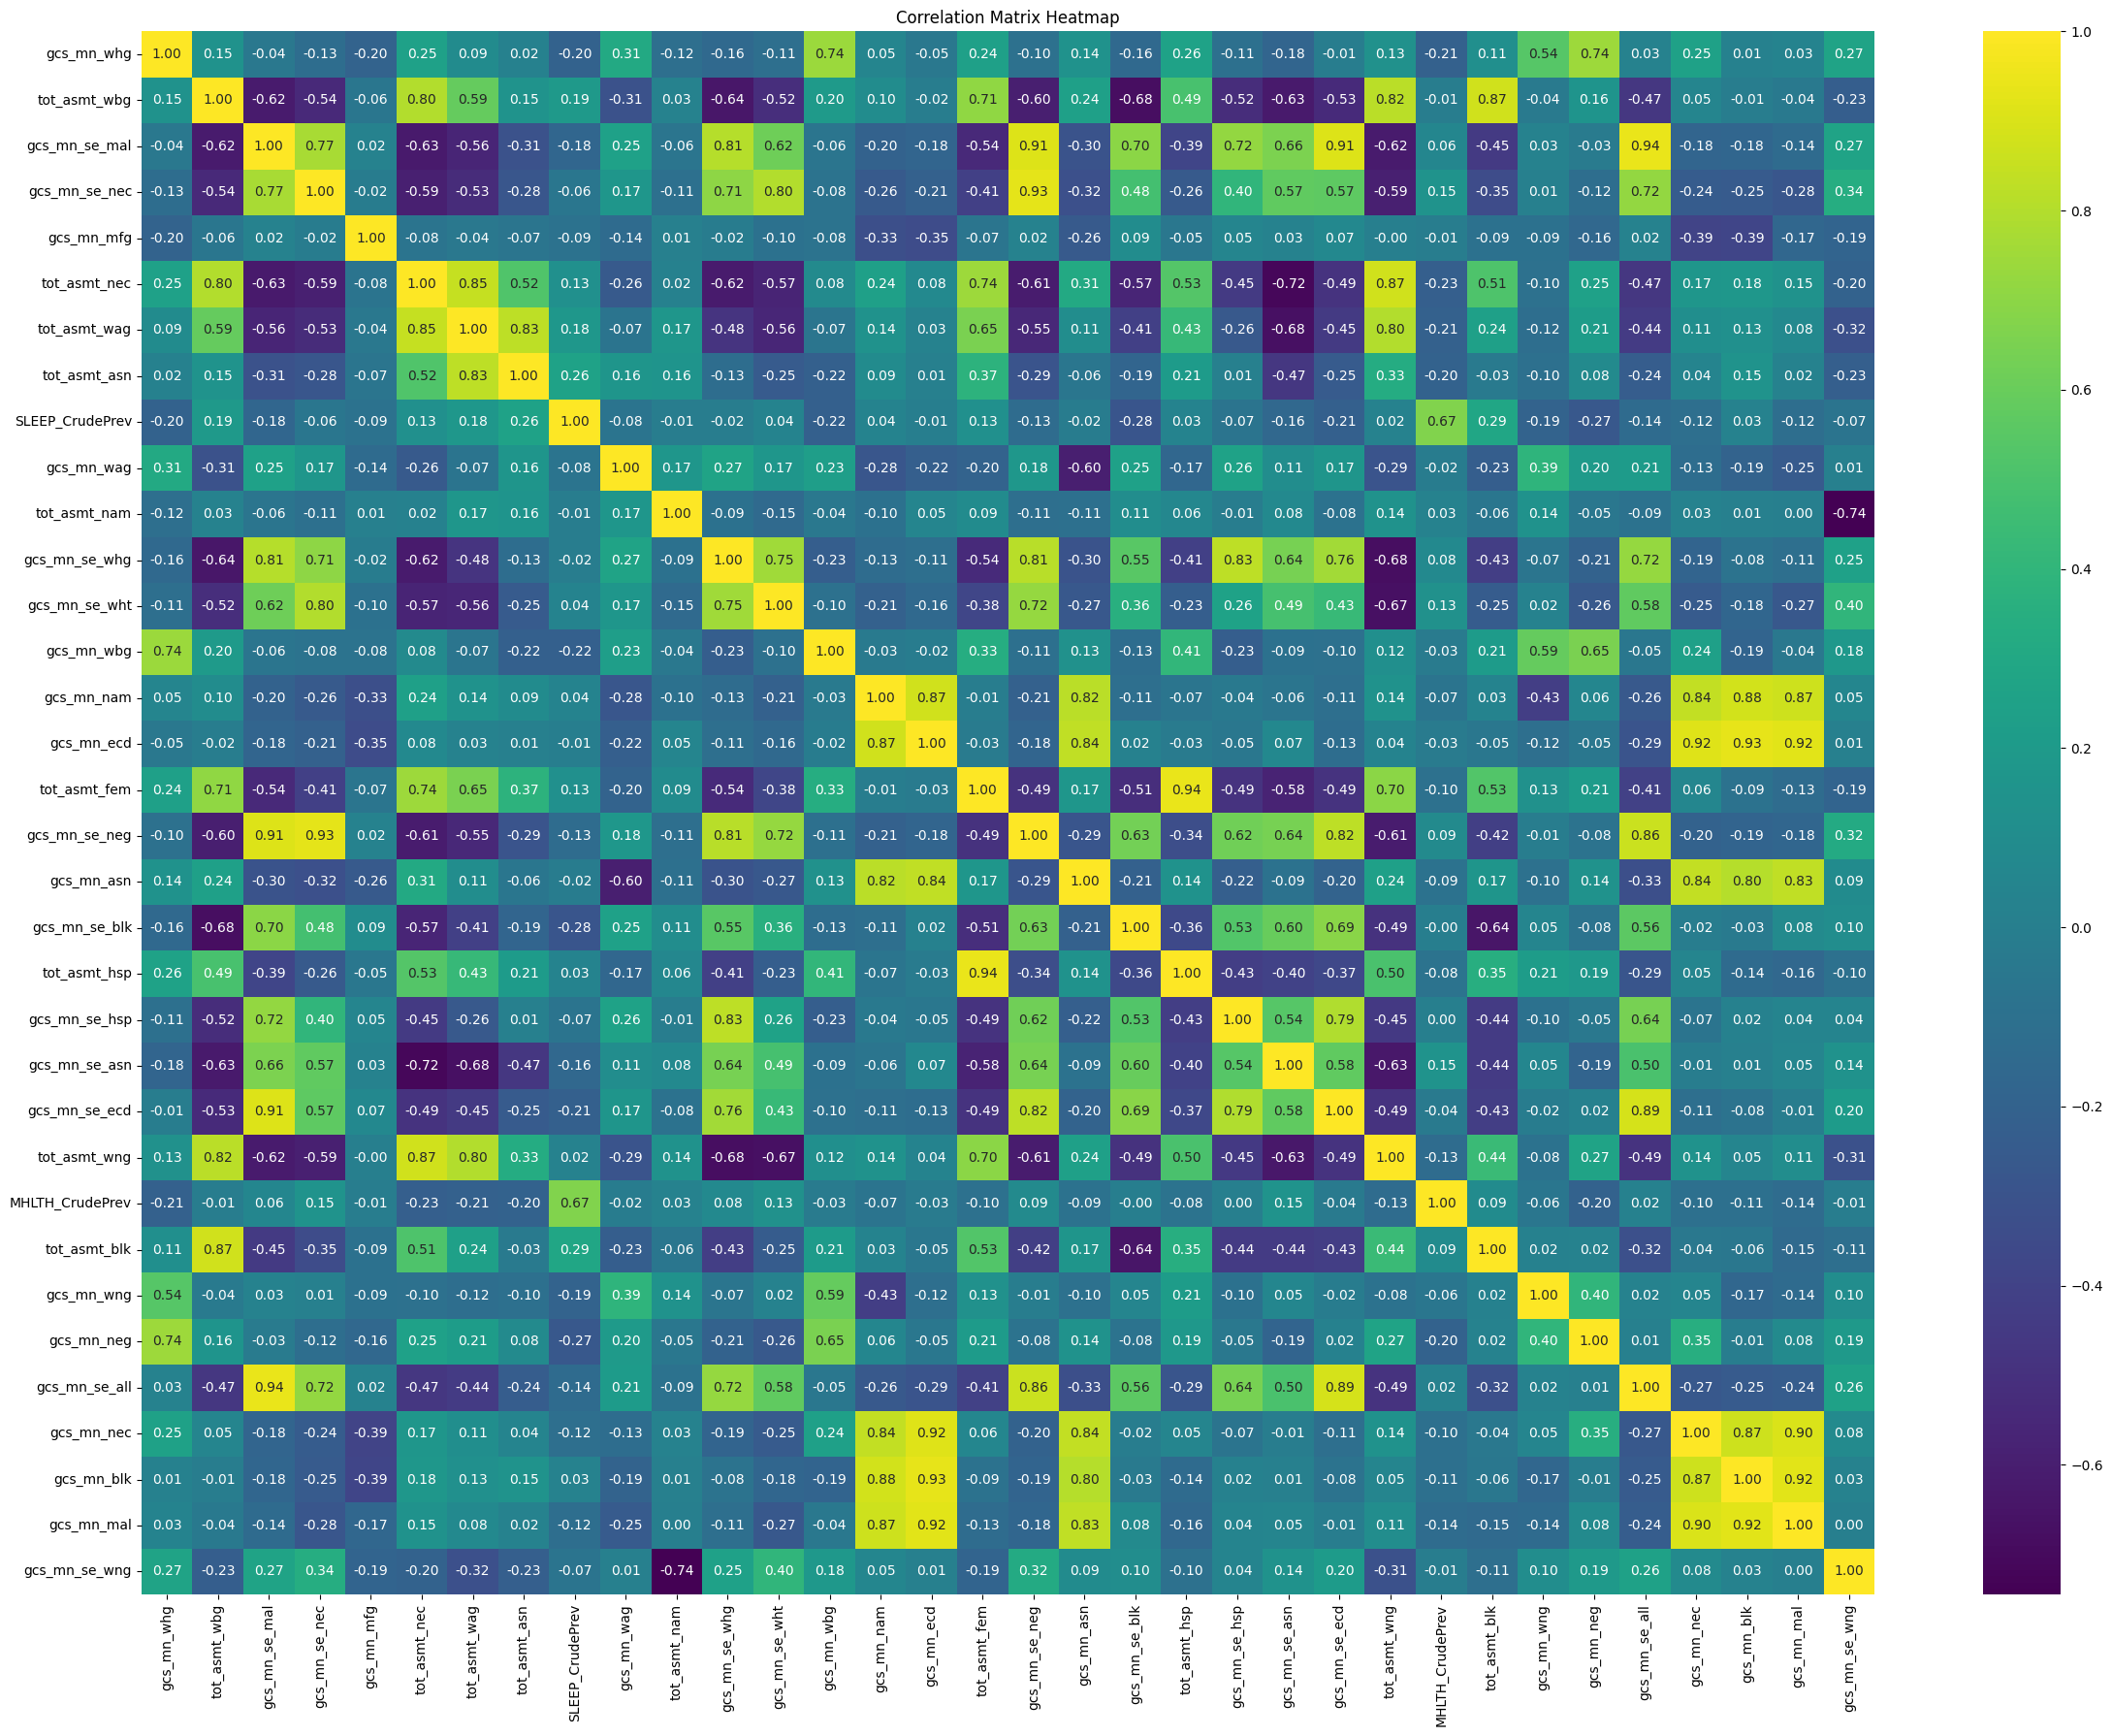

Removed: ['tot_asmt_all', 'gcs_mn_all', 'gcs_mn_se_nam', 'tot_asmt_mal', 'tot_asmt_ecd', 'gcs_mn_se_mfg', 'tot_asmt_mfg', 'gcs_mn_se_wag', 'gcs_mn_hsp', 'gcs_mn_se_wbg', 'tot_asmt_neg', 'gcs_mn_wht', 'tot_asmt_whg', 'gcs_mn_fem', 'gcs_mn_se_fem', 'tot_asmt_wht']


In [9]:
uncorrelated_features, correlated_features = u.de_correlate(race_df[feature_cols])
corr_map = race_df[uncorrelated_features].corr()
plt.figure(figsize=(24, 18))
sns.heatmap(corr_map, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()
print(f"Removed: {correlated_features}")

In [10]:
race_df_no_corr_mth = race_df[race_df.subject == "mth"].drop(correlated_features, axis=1)
race_df_no_corr_rla = race_df[race_df.subject == "rla"].drop(correlated_features, axis=1)
print(f"Math df length: {len(race_df_no_corr_mth)}")
print(f"Reading/Language Arts df length: {len(race_df_no_corr_rla)}")

Math df length: 45574
Reading/Language Arts df length: 48939


In [ ]:
param_grid = {
    "learning_rate": [0.1, 0.03, 0.01],
    "n_estimators": [100, 200, 300],
    "max_depth": [16, 32, 64],
}

param_combinations = list(product(
    param_grid["learning_rate"],
    param_grid["n_estimators"],
    param_grid["max_depth"]
))

datasets = [("Math", race_df_no_corr_mth), ("RLA", race_df_no_corr_rla)]
best_params = {
    "Math": {},
    "RLA": {}
}
for dataset in datasets:
    name, df = dataset
    print(f"Dataset: {name}")

    X = df[uncorrelated_features]

    one_hot = OneHotEncoder(sparse_output=False)
    one_hot.fit(df.y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X, df.y, test_size=0.2, random_state=42)
    label_counts = y_test.value_counts()
    print(f"Baseline accuracy: {label_counts.max() / label_counts.sum():.4f}")

    param_results = {}
    for lr, n_estimators, max_depth in param_combinations:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            y_cv_train = one_hot.transform(y_cv_train.values.reshape(-1, 1))
            y_cv_val = one_hot.transform(y_cv_val.values.reshape(-1, 1))
            y_cv_train = y_cv_train.argmax(axis=1)
            y_cv_val = y_cv_val.argmax(axis=1)

            scaler = StandardScaler()
            X_cv_train = scaler.fit_transform(X_cv_train.values)
            X_cv_val = scaler.transform(X_cv_val.values)

            model = xgb.XGBClassifier(
                objective="multi:softmax",
                num_class=3,
                learning_rate=lr,
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42,
                device="cuda"
            )
            weights = compute_sample_weight(class_weight="balanced", y=y_cv_train)
            model.fit(X_cv_train, y_cv_train, verbose=False, sample_weight=weights)
            cv_scores.append(model.score(X_cv_val, y_cv_val))

        print(f"[{lr}|{n_estimators}|{max_depth}] Val accuracy: {np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}")
        param_results[(lr, n_estimators, max_depth)] = np.mean(cv_scores)

    best_params[name] = max(param_results, key=param_results.get)

print(best_params)



Dataset: Math
Baseline accuracy: 0.8383


/home/devcontainers/venvs/cs1951a_venv/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [22:56:52] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[0.1|100|16] Val accuracy: 0.8982 +/- 0.0046
[0.1|100|32] Val accuracy: 0.9150 +/- 0.0030
[0.1|100|64] Val accuracy: 0.9150 +/- 0.0031
[0.1|200|16] Val accuracy: 0.9132 +/- 0.0032
[0.1|200|32] Val accuracy: 0.9191 +/- 0.0027
[0.1|200|64] Val accuracy: 0.9193 +/- 0.0024
[0.1|300|16] Val accuracy: 0.9179 +/- 0.0024
[0.1|300|32] Val accuracy: 0.9200 +/- 0.0022
[0.1|300|64] Val accuracy: 0.9208 +/- 0.0025
[0.03|100|16] Val accuracy: 0.8583 +/- 0.0053
[0.03|100|32] Val accuracy: 0.8934 +/- 0.0049
[0.03|100|64] Val accuracy: 0.8931 +/- 0.0046
[0.03|200|16] Val accuracy: 0.8830 +/- 0.0057
[0.03|200|32] Val accuracy: 0.9084 +/- 0.0043
[0.03|200|64] Val accuracy: 0.9103 +/- 0.0031
